In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import warnings
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Activation,BatchNormalization,Conv2D,Dense,Dropout,Flatten,GlobalAveragePooling2D,Input,Lambda,MaxPool2D
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

## *checking the data*

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# #use this only w/ GPU
# set_global_policy('mixed_float16')

In [4]:
# Enable legacy convolution operations (Fix for grouped convolutions issue)
os.environ["TF_USE_LEGACY_FUSED_CONV"] = "1"

In [7]:
hap = cv2.imread('/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test/happiness/PrivateTest_218533.jpg')

In [8]:
type(hap)

numpy.ndarray

In [9]:
hap.shape

(48, 48, 3)

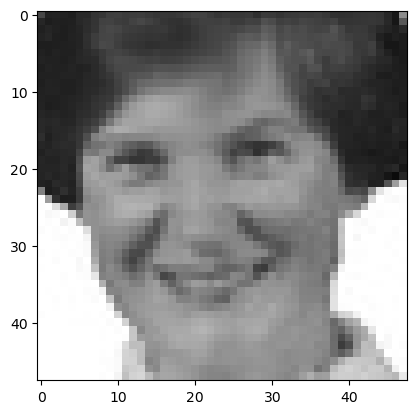

In [10]:
plt.imshow(hap);

In [11]:
dis = cv2.imread('/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test/disgust/PrivateTest_3929526.jpg')

In [12]:
type(dis)

numpy.ndarray

In [13]:
dis.shape

(48, 48, 3)

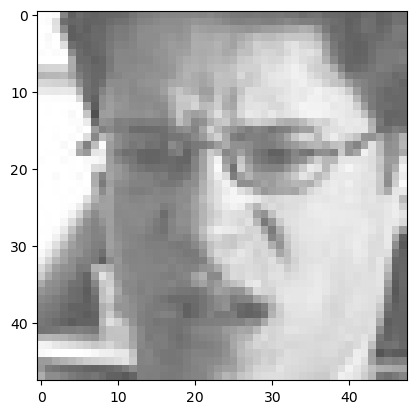

In [14]:
plt.imshow(dis);

## *preprocessing the data*

In [15]:
image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                              )

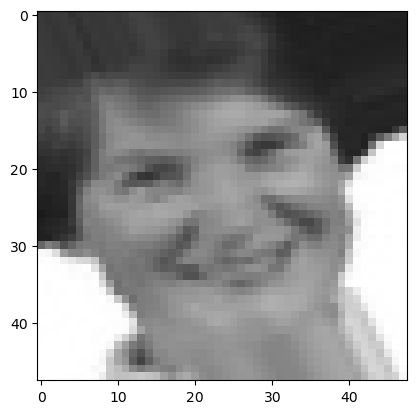

In [16]:
plt.imshow(image_gen.random_transform(hap));

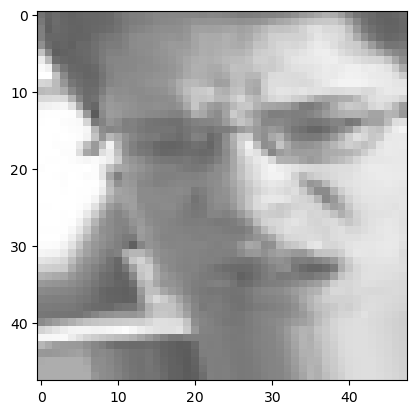

In [17]:
plt.imshow(image_gen.random_transform(dis));

In [18]:
# Define the directory paths and parameters
batch_size = 16
image_shape = (224, 224, 3)
train_dir = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/train'
test_dir = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test'

In [19]:
# Create a training ImageDataGenerator with augmentations:
train_aug_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
# Create a validation ImageDataGenerator that does only rescaling:
val_gen = ImageDataGenerator(rescale=1/255)

In [21]:
# Create training image generator
train_image_gen = train_aug_gen.flow_from_directory(
    train_dir,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.


In [22]:
# Create testing image generator
test_image_gen = val_gen.flow_from_directory(
    test_dir,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 7178 images belonging to 7 classes.


In [23]:
train_image_gen.class_indices

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [24]:
# Improved model using transfer learning.
model = Sequential([
    Input(shape=image_shape),  # Now expecting (224,224,3)
    EfficientNetB0(weights="imagenet", include_top=False, input_shape=image_shape),
    GlobalAveragePooling2D(),
    Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(7, activation="softmax")  # 7 emotion classes
])

# Unfreeze the top 20 layers of EfficientNetB0 for fine-tuning.
# The EfficientNetB0 is the second layer in our Sequential model.
for layer in model.layers[0].layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()

2025-02-12 18:38:11.110664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 4,709,034
Trainable params: 4,667,011
Non-trainable params: 42,023
_________________________________________

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',             # 1. This specifies that the callback will monitor the validation loss.
    patience=10,                     # 2. If the monitored quantity (val_loss) does not improve for 5 consecutive epochs, training will be stopped.
    min_delta=0.01,                 # 3. Only consider an epoch as "improved" if the validation loss drops by at least 0.01.
    restore_best_weights=True,      # 4. After stopping, the model weights will be reverted to those of the epoch with the best (lowest) validation loss.
    verbose=1                       # 5. Enables detailed logging so that you are informed when early stopping triggers.
)

In [26]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # 1. This specifies that the callback will monitor the validation loss.
    factor=0.7,             # 2. Reduces LR to 70% of its current value (less drastic than halving).
    min_delta=0.005,        # 3. Only trigger LR reduction if the loss improvement is less than 0.005.
    patience=5,             # 4. The learning rate will be reduced if no improvement in validation loss is observed for 5 epochs.
    verbose=1               # 5. Enables detailed logging so that you can see when the learning rate is reduced.
)

In [27]:
# Dynamically Compute Steps per Epoch
steps_per_epoch = max(1, train_image_gen.samples // train_image_gen.batch_size)
validation_steps = max(1, test_image_gen.samples // test_image_gen.batch_size)

In [28]:
results = model.fit(train_image_gen,epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_image_gen,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1794/1794 [==============================] - 5629s 3s/step - loss: 1.6720 - accuracy: 0.4871 - val_loss: 1.9533 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 2/100
1794/1794 [==============================] - 5596s 3s/step - loss: 1.3780 - accuracy: 0.5629 - val_loss: 2.0692 - val_accuracy: 0.1330 - lr: 0.0010
Epoch 3/100
1794/1794 [==============================] - 5530s 3s/step - loss: 1.3230 - accuracy: 0.5892 - val_loss: 1.9843 - val_accuracy: 0.1749 - lr: 0.0010
Epoch 4/100
1794/1794 [==============================] - 5471s 3s/step - loss: 1.2889 - accuracy: 0.6073 - val_loss: 6.2250 - val_accuracy: 0.1426 - lr: 0.0010
Epoch 5/100
1794/1794 [==============================] - 5506s 3s/step - loss: 1.2576 - accuracy: 0.6216 - val_loss: 1.7455 - val_accuracy: 0.3146 - lr: 0.0010
Epoch 6/100
1794/1794 [==============================] - 5509s 3s/step - loss: 1.2386 - accuracy: 0.6317 - val_loss: 1.9464 - val_accuracy: 0.1324 - lr: 0.0010
Epoch 7/100
1794/1794 [=================

KeyboardInterrupt: 

In [ ]:
model.save("basic_efficientnet_fer_model.keras", save_format="keras")

In [ ]:
model.save("basic_efficientnet_fer_model", save_format="tf")
print("CNN model saved successfully as 'final_cnn_model'.")